# Проведение A/B-тестирования и анализ результатов

У нас есть развлекательное приложение с функцией «бесконечной» ленты в формате видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Необходимо провести A/B-тест, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Мы будем работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Задача
Рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

## Работа с историческими данными 

### Загрузка исторических данных
На первом этапе поработаем с историческими данными приложения:

- Импортируем все необходимые библиотеки, которые понадобятся в расчёте.

- Импортируем и сохраним в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`. Выведем на экран первые пять строк полученного датафрейма.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from math import ceil
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

In [2]:
sessions_history = pd.read_csv('/datasets/sessions_project_history.csv')
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


### Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитаем количество уникальных сессий `session_id`.

- Выведем на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий.

- Изучим полученную таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [3]:
# Рассчитаем для каждого пользователя кол-во уникальных сессий, отсортировав кол-во сессий по убыванию
uniq_user_session = sessions_history.groupby('user_id')['session_id'].nunique().reset_index().sort_values(by = 'session_id', ascending = False)
uniq_user_session

,user_id,session_id
8948,10E0DEFC1ABDBBE0,10
55627,6A73CB5566BB494D,10
72346,8A60431A825D035B,9
109383,D11541BAC141FB94,9
47956,5BCFE7C4DCC148E9,9
...,...,...
15859,1DF13BB1953B3497,1
51449,628502A3CE7E0A3C,1
15853,1DEEF40DEFBD0C65,1
89905,AC08479B7472C628,1


In [4]:
# Выведем данные по пользователю с наибольшим количеством уникальных сессий
lider_user = sessions_history[sessions_history['user_id'] == '10E0DEFC1ABDBBE0']
lider_user

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


### Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируем, как менялось число регистраций в приложении за время его существования.

- Агрегируем исторические данные и рассчитаем число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения.

- Построим линейные графики динамики общего числа пользователей и общего числа зарегистрированных пользователей по дням.

- Построим отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.


In [5]:
# Группируем данные по дате сессии и флагу регистрации пользователя и расчитаем кол-во пользователей
df_grp = sessions_history.groupby(['session_date','registration_flag'])['user_id'].count().reset_index()
df_grp.head(10)

,session_date,registration_flag,user_id
0,2025-08-11,0,3750
1,2025-08-11,1,169
2,2025-08-12,0,5720
3,2025-08-12,1,336
4,2025-08-13,0,8025
5,2025-08-13,1,464
6,2025-08-14,0,9696
7,2025-08-14,1,625
8,2025-08-15,0,13225
9,2025-08-15,1,840


In [6]:
# Посчитаем общее кол-во пользователей по дням
df_sum_users = df_grp.groupby('session_date')['user_id'].sum().reset_index()
df_sum_users.head()

,session_date,user_id
0,2025-08-11,3919
1,2025-08-12,6056
2,2025-08-13,8489
3,2025-08-14,10321
4,2025-08-15,14065


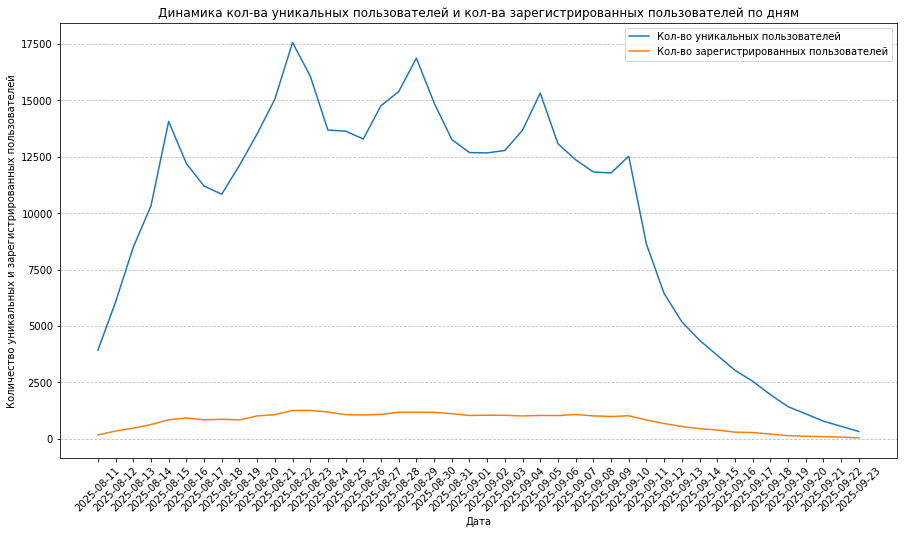

In [7]:
# Построим линейный график общего числа пользователей и общего числа зарегистрированных пользователей по дням
# Выведем значения осей в соответствии с заданием
x = df_grp.session_date.unique()
y_a = df_sum_users.user_id
y_b = df_grp[df_grp.registration_flag==1].user_id

plt.figure(figsize=(15, 8))
plt.plot(x, y_a, label ='Кол-во уникальных пользователей')
plt.plot(x, y_b,label ='Кол-во зарегистрированных пользователей')

plt.xlabel("Дата")
plt.ylabel("Количество уникальных и зарегистрированных пользователей")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.5, linestyle='--', color='gray')
plt.legend()
plt.title('Динамика кол-ва уникальных пользователей и кол-ва зарегистрированных пользователей по дням')
plt.show()

In [8]:
# Отдельно сохраним датафрейм с зарегистрированными пользователям
df_true_req = df_grp[df_grp['registration_flag'] ==1]
df_true_req.head()

,session_date,registration_flag,user_id
1,2025-08-11,1,169
3,2025-08-12,1,336
5,2025-08-13,1,464
7,2025-08-14,1,625
9,2025-08-15,1,840


In [9]:
# Объединим датафреймы
df_unit = df_true_req.merge(df_sum_users, how = 'left', on = 'session_date', suffixes=('_reg', '_total'))
df_unit.rename(columns={'user_id_reg': 'reg_users', 'user_id_total': 'total_users'}, inplace=True)
# Расчёт доли зарегистрированных пользователей от всех пользователей по дням
df_unit['share_reg_users'] = round(df_unit['reg_users'] / df_unit['total_users'] * 100.0, 2)
df_unit.tail()

,session_date,registration_flag,reg_users,total_users,share_reg_users
39,2025-09-19,1,132,1418,9.31
40,2025-09-20,1,107,1100,9.73
41,2025-09-21,1,87,776,11.21
42,2025-09-22,1,68,546,12.45
43,2025-09-23,1,32,317,10.09


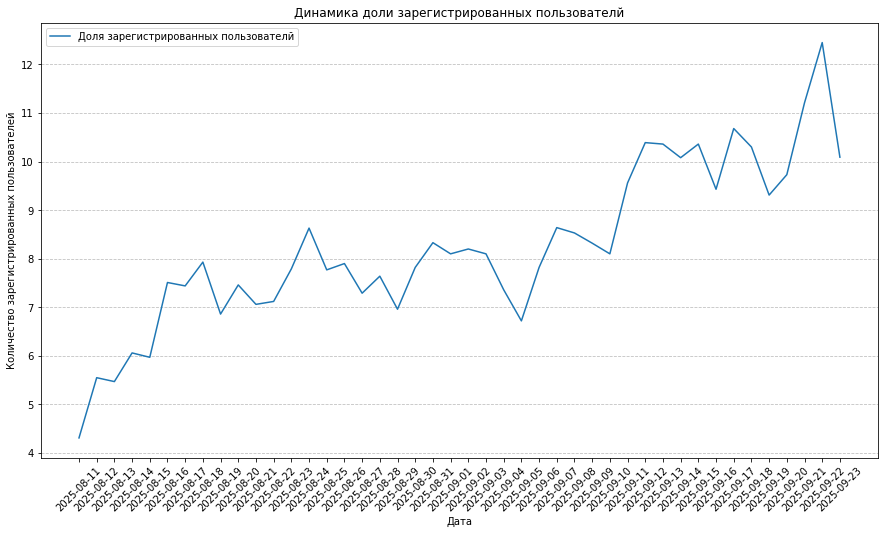

In [10]:
# Выведем значения осей в соответствии с заданием
x = df_unit.session_date.unique()
y = df_unit.share_reg_users

plt.figure(figsize=(15, 8))
plt.plot(x, y, label ='Доля зарегистрированных пользователй')

plt.xlabel("Дата")
plt.ylabel("Количество зарегистрированных пользователей")
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.5, linestyle='--', color='gray')
plt.title('Динамика доли зарегистрированных пользователй')
plt.show()

**Промежуточный вывод**
- Наблюдается выраженный рост доли зарегистрированных пользователей (share_reg_users) с 4,31% (11 августа) до пикового значения в 12,4% - 21 сентября 2025 года, далее происходит снижение доли до 10,1%.
- Максимальное значение зафиксировано 22 сентября - 12.45%.
- Стремительный рост может быть обусловлен успехом рекламной кампании или оптимизации просесса регистрации.

### Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.

- Найдем количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29160 сессиях, две страницы в 105536 сессиях и так далее.

- Построим столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

In [11]:
# Выведем первые 5 строк датафрейма
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


In [12]:
# Выведем уникальные значения кол-ва просмотренных страниц
sessions_history['session_number'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [13]:
# Выведем количество сессий для каждого значения кол-ва просмотренных страниц
sessions = sessions_history.groupby('page_counter')['session_id'].count().reset_index()
sessions

,page_counter,session_id
0,1,29160
1,2,105536
2,3,166690
3,4,105569
4,5,26288
5,6,2589
6,7,92


<Figure size 720x360 with 0 Axes>

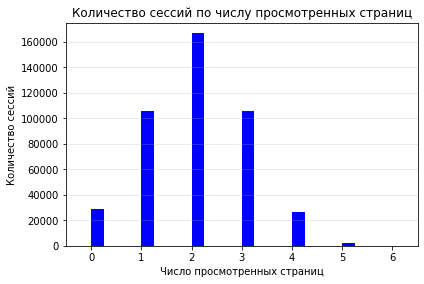

In [14]:
# Построим столбчатую диаграмму количества сессий по числу просмотренных страниц

plt.figure(figsize=(10, 5))
sessions.plot(kind='bar', color='blue', legend=False)

# Добавляем заголовки и метки осей
plt.title('Количество сессий по числу просмотренных страниц')
plt.xlabel('Число просмотренных страниц')
plt.ylabel('Количество сессий')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.xticks(rotation=0)

# Отображаем диаграмму
plt.show()

### Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Построим график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения.

In [15]:
# Добавим в датафрейм sessions_history новое поле good_session с помощью лямбда-функции

sessions_history['good_session'] = sessions_history['page_counter'].apply(lambda x: 1 if x >= 4 else 0)
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,good_session
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone,0
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android,1
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC,1
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android,1
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android,0


In [16]:
# Выведем долю успешных сессий по дням
good_ses = sessions_history.groupby('session_date')['good_session'].mean().reset_index()
good_ses = good_ses.rename(columns={'good_session': 'good_session_share'})
good_ses.head()

,session_date,good_session_share
0,2025-08-11,0.312835
1,2025-08-12,0.302015
2,2025-08-13,0.306750
3,2025-08-14,0.316055
4,2025-08-15,0.304941


In [17]:
# Установим поле с датой, как индекс, чтобы корректно отобразить ось Х на графике
good_ses = good_ses.set_index('session_date')

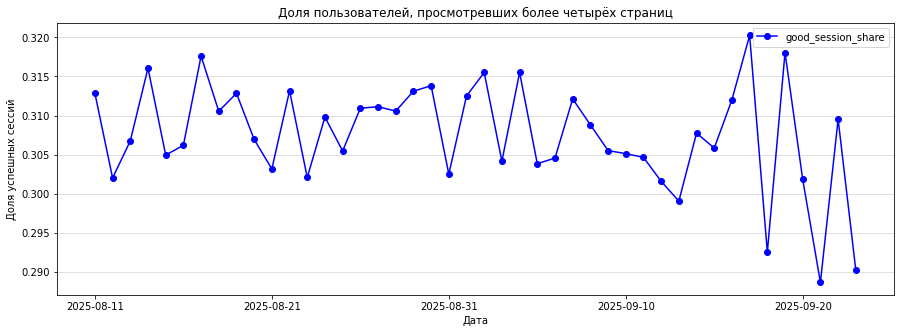

In [18]:
# Создаем график
plt.figure(figsize=(15, 5))
good_ses['good_session_share'].plot(marker='o', linestyle='-', color='b')

# Добавляем заголовки и метки осей
plt.title('Доля пользователей, просмотревших более четырёх страниц')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.5)
plt.legend()


# Отображаем график
plt.show()

**Промежуточный вывод**
- Доля пользователей, просмотревших более 4-х страниц имеет нестабильную динамику по дням, наибольший размах колебания метрики день ко дню наблюдался во второй половине сентября.

### Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика, рассчитать необходимую длительность проведения теста.

#### Расчёт размера выборки

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки мы будем использовать метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.


In [19]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### Расчёт длительности A/B-теста

Используем данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитаем длительность теста.

- Рассчитаем среднее количество уникальных пользователей приложения в день.

- Определим длительность теста, исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения.

In [20]:
# Выведем первые 5 строк датафрейма, где хранится общее кол-во уникальных пользователей по дням
df_sum_users.head()

,session_date,user_id
0,2025-08-11,3919
1,2025-08-12,6056
2,2025-08-13,8489
3,2025-08-14,10321
4,2025-08-15,14065


In [21]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = int(df_sum_users['user_id'].mean().round())

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size * 2/avg_daily_users) # Умножаем на 2, так как необходимо учесть две выборки

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дня")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907 пользователей в день составит 4 дня


**Промежуточный вывод**
- На основании проведённых расчётов установлено, что для проведения A/B-теста при текущем уровне трафика в 9907 пользователей в день потребуется всего 4 дня. Это означает, что за такой короткий срок можно будет собрать достаточное количество данных для анализа и определения статистически значимых различий между тестируемыми группами.

## Мониторинг А/В-теста

### Проверка распределения пользователей

A/B-тест был успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие нас метрики корректно считаются.

- Посчитаем и сохраним в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитаем и выведем на экран процентную разницу в количестве пользователей в группах A и B. Построим визуализацию, на которой будет видно различие двух групп.

Для расчёта процентной разницы воспользуемся формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [22]:
sessions_test_part = pd.read_csv('/datasets/sessions_project_test_part.csv')
sessions_test_part.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [23]:
# Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения
group_A_users = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].nunique()
group_B_users = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].nunique()
print (f'Количество уникальных пользователей в группе А: {group_A_users}, в группе В: {group_B_users}')

Количество уникальных пользователей в группе А: 1477, в группе В: 1466


In [24]:
# Рассчитаем процентную разницу в количестве пользователей в группах A и B

percentage_diff = round(((group_A_users - group_B_users) / group_B_users) * 100.0, 2)
percentage_diff

0.75

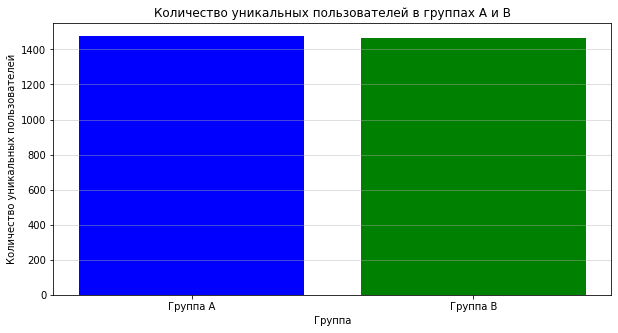

In [25]:
# Построение столбчатой диаграммы для визуализации разницы
plt.figure(figsize=(10, 5))
plt.bar(['Группа A', 'Группа B'], [group_A_users, group_B_users], color=['blue', 'green'])
plt.title('Количество уникальных пользователей в группах A и B')
plt.xlabel('Группа')
plt.ylabel('Количество уникальных пользователей')
plt.grid(axis='y', alpha=0.5)
plt.show()

**Промежуточный вывод**
- Процентная разница в количестве пользователей между группами A и B составляет 0,75%, что означает, что количество пользователей в одной из групп на 0,75% больше или меньше, чем в другой группе. В контексте эксперимента это может указывать на небольшое различие в количестве уникальных пользователей между группами. Если разница небольшая, как в данном случае, это может свидетельствовать о том, что влияние тестируемого фактора на количество пользователей минимально или что различия в выборках незначительны.

### Проверка пересечений пользователей
Необходимо убедиться, что никто из пользователей случайно не попал в обе группы теста одновременно.

- Рассчитайте количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [26]:
# Получаем уникальные идентификаторы пользователей для каждой группы
set_A_users = set(sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].unique())
set_B_users = set(sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].unique())

# Находим пересечение двух наборов пользователей через intersection
common_users = set_A_users.intersection(set_B_users)
# Выводим количество общих пользователей
print(f"Количество пользователей, которые встречаются одновременно в группах A и B: {len(common_users)}")

Количество пользователей, которые встречаются одновременно в группах A и B: 0


In [27]:
# Проверил новый метод
sessions_test_part.groupby('user_id').agg({'test_group': 'nunique'}).query('test_group > 1').reset_index()

,user_id,test_group


Убедились, что пересечений пользователей в группах А и В нет.

### Равномерность разделения пользователей по устройствам
Убедимся в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.

Построим две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

In [28]:
# Сгруппируем данные таблицы по тестовой группе и устройствам, посчитаем кол-во пользователей
df_device = sessions_test_part.groupby(['test_group', 'device'])['user_id'].nunique().reset_index()
df_device

,test_group,device,user_id
0,A,Android,656
1,A,Mac,156
2,A,PC,369
3,A,iPhone,296
4,B,Android,668
5,B,Mac,148
6,B,PC,381
7,B,iPhone,269


In [29]:
# Рассчитываем количество и долю пользователей по группе А в разбивке по устройствам

df_device_A = df_device[df_device['test_group'] == 'A'][['device', 'user_id']]
df_device_A['device_share'] = round(df_device_A['user_id'] / df_device_A['user_id'].sum() * 100, 2)

# Выведем данные только по типу устройства и доле пользователей и сохраним в отдельный датафрейм
df_device_A_share = df_device_A[['device', 'device_share']]
df_device_A_share

,device,device_share
0,Android,44.41
1,Mac,10.56
2,PC,24.98
3,iPhone,20.04


<Figure size 720x360 with 0 Axes>

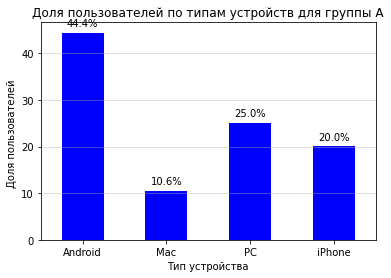

In [30]:
# Построение диаграммы для группы A по девайсам

x = df_device_A_share['device']
y = df_device_A_share['device_share']

plt.figure(figsize=(10, 5))
ax = df_device_A_share.plot(kind='bar', color='blue', legend=False)

# Добавляем заголовки и метки осей
plt.title('Доля пользователей по типам устройств для группы A')
plt.xlabel('Тип устройства')
plt.ylabel('Доля пользователей ')
plt.grid(axis='y', alpha=0.5)
plt.xticks(rotation=0)

# Устанавливаем метки для оси X
plt.xticks(range(len(df_device_A_share)), df_device_A_share['device'], rotation=0)

# Добавляем подписи на столбцах
for i, v in enumerate(df_device_A_share['device_share']):
    ax.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontsize=10)

# Отображаем диаграмму
plt.show()

In [31]:
# Рассчитываем количество и долю пользователей по группе B в разбивке по устройствам
df_device_B = df_device[df_device['test_group'] == 'B'][['device', 'user_id']]
df_device_B['device_share'] = round(df_device_B['user_id'] / df_device_B['user_id'].sum() * 100, 2)

# Выведем данные только по типу устройства и доле пользователей и сохраним в отдельный датафрейм
df_device_B_share = df_device_B[['device', 'device_share']]
df_device_B_share

,device,device_share
4,Android,45.57
5,Mac,10.10
6,PC,25.99
7,iPhone,18.35


<Figure size 720x360 with 0 Axes>

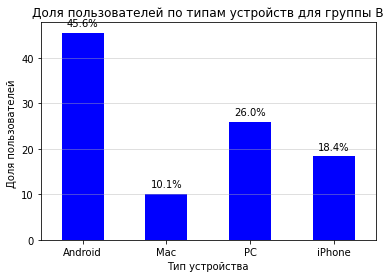

In [32]:
# Построение диаграммы для группы В по девайсам

x = df_device_B_share['device']
y = df_device_B_share['device_share']

plt.figure(figsize=(10, 5))
ax = df_device_B_share.plot(kind='bar', color='blue', legend=False)

# Добавляем заголовки и метки осей
plt.title('Доля пользователей по типам устройств для группы В')
plt.xlabel('Тип устройства')
plt.ylabel('Доля пользователей ')
plt.grid(axis='y', alpha=0.5)
plt.xticks(rotation=0)

# Устанавливаем метки для оси X
plt.xticks(range(len(df_device_B_share)), df_device_B_share['device'], rotation=0)

# Добавляем подписи на столбцах
for i, v in enumerate(df_device_B_share['device_share']):
    ax.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontsize=10)

# Отображаем диаграмму
plt.show()

### Равномерность распределения пользователей по регионам
Убедимся, что пользователи равномерно распределены по регионам.

Построим две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

In [33]:
# Выведем еще раз первые 5 строк датафрейма с результатами теста
sessions_test_part.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [34]:
# Выведем уникальные значения регионов
sessions_test_part['region'].unique()

array(['CIS', 'MENA', 'EU'], dtype=object)

In [35]:
# Сгруппируем данные таблицы по тестовой группе и регионам, посчитаем кол-во пользователей
df_region = sessions_test_part.groupby(['test_group', 'region'])['user_id'].nunique().reset_index()
df_region

,test_group,region,user_id
0,A,CIS,644
1,A,EU,224
2,A,MENA,609
3,B,CIS,645
4,B,EU,217
5,B,MENA,604


In [37]:
# Рассчитываем количество и долю пользователей по группе А в разбивке по регионам

df_region_A = df_region[df_region['test_group'] == 'A'][['region', 'user_id']]
df_region_A['region_share'] = round(df_region_A['user_id'] / df_region_A['user_id'].sum() * 100, 2)
df_region_A

# Выведем данные только по типу устройства и доле пользователей и сохраним в отдельный датафрейм
df_region_A_share = df_region_A[['region', 'region_share']]
df_region_A_share

,region,region_share
0,CIS,43.60
1,EU,15.17
2,MENA,41.23


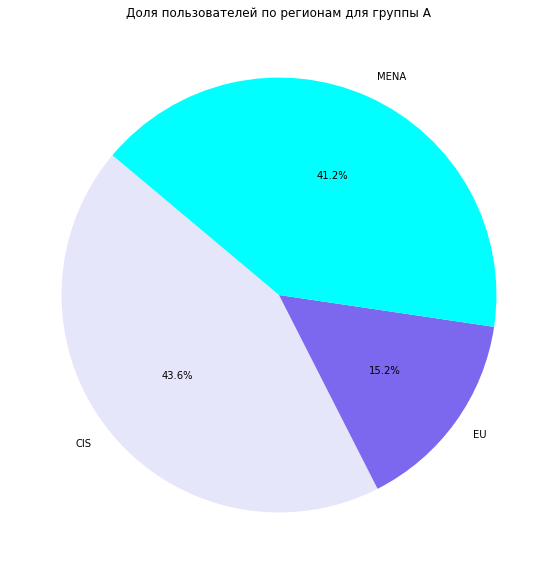

In [38]:
# Построение круговой диаграммы для группы A по регионам
x = df_region_A_share['region']
y = df_region_A_share['region_share']

plt.figure(figsize=(10, 10))

# Строим круговую диаграмму
plt.pie(y, labels=x, autopct='%.1f%%', startangle=140, colors=['#E6E6FA', '#7B68EE', '#00FFFF']) 

# Добавляем заголовок
plt.title('Доля пользователей по регионам для группы A')

# Отображаем диаграмму
plt.show()


In [38]:
# Рассчитываем количество и долю пользователей по группе B в разбивке по регионам

df_region_B = df_region[df_region['test_group'] == 'B'][['region', 'user_id']]
df_region_B['region_share'] = round(df_region_B['user_id'] / df_region_B['user_id'].sum() * 100, 2)
df_region_B

# Выведем данные только по типу устройства и доле пользователей и сохраним в отдельный датафрейм
df_region_B_share = df_region_B[['region', 'region_share']]
df_region_B_share

,region,region_share
3,CIS,44.0
4,EU,14.8
5,MENA,41.2


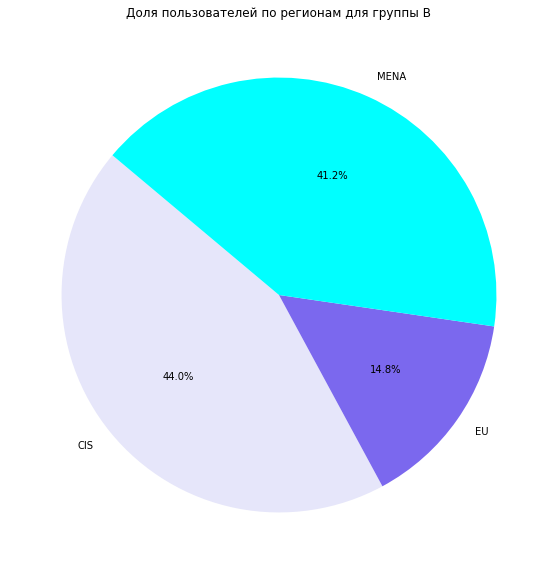

In [39]:
# Построение круговой диаграммы для группы B по регионам

x = df_region_B_share['region']
y = df_region_B_share['region_share']

plt.figure(figsize=(10, 10))

# Строим круговую диаграмму
plt.pie(y, labels=x, autopct='%.1f%%', startangle=140, colors=['#E6E6FA', '#7B68EE', '#00FFFF']) 

# Добавляем заголовок
plt.title('Доля пользователей по регионам для группы B')

# Отображаем диаграмму
plt.show()


**Промежуточный вывод:**

- В обоих тестовых группах пользователи, в разбивке по устройстам, кол-во пользвателей больше преобладает у типа 'Android' занимая долю пользователей в группе А - 44,4%, в группе В - 45,5%, на втором месте 'PC', доля пользователей в группе А - 24,9%, в группе В - 25,9%, на третьем месте месте 'IPhone', доля пользователей в группе А - 20,0%, в группе В - 18,3%, на четвертом месте 'Mac', доля пользователей в группе А - 10,5%, в группе В - 10,1%.  Общая тенденция распределения по устройствам идентична, существенных изменений в метрике не выявлено, различия составляют менее 2 п.п., что можно считать незначительным.
- В обоих тестовых группах пользователи, в разбивке по регионам, кол-во пользвателей больше преобладает в регионе 'MENA' занимая долю пользователей в группе А - 41,2%, в группе В - 41,2%, на втором месте 'CIS', доля пользователей в группе А - 43,6%, в группе В - 44,0%, на третьем месте месте 'EU', доля пользователей в группе А - 15,2%, в группе В - 14,8%. Общая тенденция распределения не нарушена, существенных изменений в метрике также не выявлено, различия составляют менее 1 п.п., что можно считать незначительным.
- Выборки являются независимыми, так как пользователей, которые встречаются одновременно в группах A и В не обнаружено.
- А/В тест проходит корректно, требуется больше времени, чтобы судить о его успешности.

## Проверка результатов A/B-теста

A/B-тест завершён, и у нас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности провденного теста и интерпретировать результаты.

### Получение результатов теста и подсчёт основной метрики

- Посчитаем и сохраним в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [40]:
sessions_test = pd.read_csv('/datasets/sessions_project_test.csv')

In [41]:
# Добавим в датафрейм sessions_test новое поле good_session с помощью лямбда-функции

sessions_test['good_session'] = sessions_test['page_counter'].apply(lambda x: 1 if x >= 4 else 0)
sessions_test.tail()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
100000,CF77C27B238C1BE3,0F7BC9B33685377C,2025-10-22,2025-10-22 19:01:50,2025-10-20,3,0,3,MENA,Android,A,0
100001,D7ED66C581409AC2,26C4475005E70F47,2025-10-17,2025-10-17 22:12:38,2025-10-17,1,0,5,CIS,PC,A,1
100002,E7EA2D51238020C6,9B9CDE6A612CBD73,2025-10-24,2025-10-24 14:54:07,2025-10-14,2,0,3,MENA,PC,B,0
100003,8A6FEFD7F34C5DA1,37291EC27106EF9D,2025-10-18,2025-10-18 00:05:10,2025-10-14,3,0,4,EU,Android,B,1
100004,EE2CA3C8481A0DE8,A4C833633CD4412E,2025-10-23,2025-10-23 10:02:27,2025-10-19,2,0,2,MENA,Android,B,0


### Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно.

- Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверим, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. Используем статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

In [42]:
# Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп
df_uniq_session_test = sessions_test.groupby(['session_date', 'test_group'])['session_id'].count().reset_index()
df_uniq_session_test.head()

,session_date,test_group,session_id
0,2025-10-14,A,1502
1,2025-10-14,B,1628
2,2025-10-15,A,2235
3,2025-10-15,B,2283
4,2025-10-16,A,3280


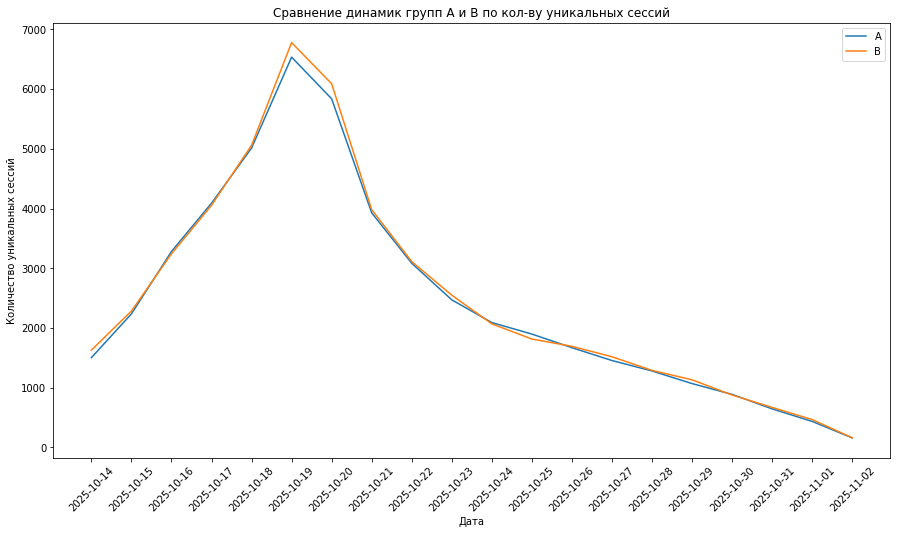

In [43]:
# Построим график сравнения динамики кол-ва уникальных сессий в обоих группах
x = df_uniq_session_test.session_date.unique()
y_a = df_uniq_session_test[df_uniq_session_test.test_group=='A'].session_id
y_b = df_uniq_session_test[df_uniq_session_test.test_group=='B'].session_id

plt.figure(figsize=(15, 8))
plt.plot(x, y_a, label ='A')
plt.plot(x, y_b,label ='B')

plt.xlabel("Дата")
plt.ylabel("Количество уникальных сессий")
plt.legend()
plt.title('Сравнение динамик групп A и B по кол-ву уникальных сессий')
plt.xticks(rotation=45)
plt.show()


**Промежуточный вывод о данных:**
- Динамика количества уникальных сессий практически одинаковая в обоих группах, что говорит о том, что группы сопоставимы по размеру в течение всего эксперимента. 

**Сформулируем гипотезы:**

- H₀: Средние значения в группах A и B равны
- H₁: Средние значения в группах A и B не равны

In [44]:
# Используем классический т-тест, который позволит сделать вывод о равенстве средних двух выборок

metric_a = df_uniq_session_test[df_uniq_session_test.test_group=='A'].session_id ## выборка целевой метрики для группы A
metric_b = df_uniq_session_test[df_uniq_session_test.test_group=='B'].session_id ## выборка целевой метрики для группы B

alpha = 0.05 ## на каком уровне значимости проверяем гипотезу о равенстве выборочных средних
stat_ttest, p_value_ttest = ttest_ind(
    metric_a, 
    metric_b, 
    alternative='two-sided' ## поскольку альтернативная гипотеза о том, что выборочное среднее первой выборки(metric_a) меньше второй выборки
) ## применяем тест Стьюдента (классический T-test)

if p_value_ttest>alpha:
    print(f'p-value теста Стьюдента ={round(p_value_ttest, 2)}')
    print('Нулевая гипотеза находит подтверждение! Средние значения в группах A и B равны')
    print('Интерпретация: Количество уникальных дневных сессий не различается между тестовой и контрольной группами.')
else:
    print(f'p-value теста Стьюдента ={round(p_value_ttest, 2)}')
    print('Нулевая гипотеза не находит подтверждения! Средние значения в группах A и B не равны')
    print('Интерпретация: количество уникальных дневных сессий различается между тестовой и контрольной группами.')

p-value теста Стьюдента =0.94
Нулевая гипотеза находит подтверждение! Средние значения в группах A и B равны
Интерпретация: Количество уникальных дневных сессий не различается между тестовой и контрольной группами.


**Промежуточный вывод**
- Внедрение новой рекомендательной системы не привело к увеличению количества уникальных сессий по сравнению с контрольной группой. На данный момент нет оснований утверждать, что новая система оказывает значимое влияние на количество уникальных сессий.

### Сравнение доли успешных сессий

Используем созданный на первом шаге задания столбец `good_session` и рассчитаем долю успешных сессий для выборок A и B, а также разницу в этом показателе.

In [45]:
sessions_test.tail()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
100000,CF77C27B238C1BE3,0F7BC9B33685377C,2025-10-22,2025-10-22 19:01:50,2025-10-20,3,0,3,MENA,Android,A,0
100001,D7ED66C581409AC2,26C4475005E70F47,2025-10-17,2025-10-17 22:12:38,2025-10-17,1,0,5,CIS,PC,A,1
100002,E7EA2D51238020C6,9B9CDE6A612CBD73,2025-10-24,2025-10-24 14:54:07,2025-10-14,2,0,3,MENA,PC,B,0
100003,8A6FEFD7F34C5DA1,37291EC27106EF9D,2025-10-18,2025-10-18 00:05:10,2025-10-14,3,0,4,EU,Android,B,1
100004,EE2CA3C8481A0DE8,A4C833633CD4412E,2025-10-23,2025-10-23 10:02:27,2025-10-19,2,0,2,MENA,Android,B,0


In [46]:
# Рассчитаем долю успешных сессий для выборок A и B
df_good_sessions_rate = sessions_test.groupby('test_group')['good_session'].mean().reset_index().round(4)
df_good_sessions_rate

,test_group,good_session
0,A,0.3077
1,B,0.3183


In [47]:
# Рассчитываем разницу в доле успешных сессий между группами A и B
diff = df_good_sessions_rate.loc[df_good_sessions_rate['test_group'] == 'B', 'good_session'].values[0] - df_good_sessions_rate.loc[df_good_sessions_rate['test_group'] == 'A', 'good_session'].values[0]
diff.round(3)

0.011

**Промежуточный вывод**
- Доля успешных сессий в тестовой группе В на 0,011 п.п. или на 1,1% выше, чем в контрольной.

### Насколько статистически значимо изменение ключевой метрики

Мы получили результат, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно, необходимо проверить: является ли это изменение статистически значимым.

**Сформулируем гипотезы:**

- H₀: Доли успешных сессий в группах A и B не различаются.
- H₁: Доли успешных сессий в группах A и B различаются.

Для проверки, какая из гипотез является истинной используем z-test, который позволяет определить, существует ли значимая разница между долями в двух независимых выборках.

Для начала проверим, выполняется ли предпосылка Z-теста пропорций о достаточном размере выборок, посчитаем количество наблюдений в каждой группе, а также — количество «успехов» в них.

In [48]:
# Посчитаем размер выборок и кол-во успехов в группах А и В

n_a, n_b = sessions_test[sessions_test.test_group=='A'].shape[0], sessions_test[sessions_test.test_group=='B'].shape[0] ## размеры выборок A и B
m_a = sessions_test[(sessions_test.test_group=='A')&(sessions_test.good_session==1)].shape[0] # количество успехов (регистраций) в группе A
m_b = sessions_test[(sessions_test.test_group=='B')&(sessions_test.good_session==1)].shape[0] # количество успехов (регистраций) в группе B

p_a, p_b = m_a/n_a, m_b/n_b # рассчитываем доли успехов для каждой группы: A и B

print(f'n_a={n_a}, n_b={n_b}')
# 49551 50454

print(f'm_a={m_a}, m_b={m_b}')
# 15248 16059

print(f'p_a={p_a}, p_b={p_b}') # Рассчитываем вероятность успеха для обеих групп
# 0.307 0.318

if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10): # Проверяем, что вероятность успеха, умноженная на размер выборки, составляет не менее 10.
    print('Предпосылка о достаточном количестве данных выполняется!') 
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

n_a=49551, n_b=50454
m_a=15248, m_b=16059
p_a=0.3077233557344958, p_b=0.31828992745867524
Предпосылка о достаточном количестве данных выполняется!


Предпосылка о дастаточном количестве данных подтвердилась, применим z-test для подтверждения одной из гипотез.

In [49]:
# Используем Z-test для проверки результата

# Общепринятый уровень значимости    
alpha = 0.05

stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='two-sided' # так как H_1: p_a != p_b
)
p_value_ztest

if p_value_ztest > alpha:
    print(f'pvalue={round(p_value_ztest,6)} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
    print('Доли успешных сессий в группах A и B не различаются!')
else:
    print(f'pvalue={round(p_value_ztest,6)} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')
    print('Доли успешных сессий в группах A и B различаются!')

pvalue=0.000315 < 0.05
Нулевая гипотеза не находит подтверждения!
Доли успешных сессий в группах A и B различаются!


##### **Промежуточный вывод**
- На основании полученного p_value теста (p = 0.000315), которое меньше общепринятого уровня значимости α = 0,05, можно сделать вывод, что нулевая гипотеза о равенстве доли успешных сессий в группах А и В отвергается, следовательно, доли успешных сессий в группах A и B значительно различаются.

### Вывод по результатам A/B-эксперимента

- Характеристики проведённого эксперимента:

Эксперимент включал анализ данных о зарегистрированных пользователях и успешных сессиях за период с 2025-10-14 по 2025-11-02. Группы A и B были независимыми, без пересечения пользователей между ними.

- Влияние нового алгоритма рекомендаций на рост ключевой метрики:

Внедрение новой рекомендательной системы не привело к увеличению количества уникальных сессий по сравнению с контрольной группой, но при этом доля успешных сессий у тестовой группы выше на 1,1%, относительно контрольной группы, что является статистически значимым изменением.

- Значение p-value для оценки статистической значимости выявленного эффекта:

P-value теста Стьюдента составило 0,94, что больше общепринятого уровня значимости (α = 0,05). Это указывает на то, что различия между группами не являются статистически значимыми, а именно что внедрение новой рекомендательной системы не привело к увеличению количества уникальных сессий по сравнению с контрольной группой, другое значение p-value z-testa составило 0.000315, что меньше общепринятого уровня значимости (α = 0,05), это указывает на то, что нулевая гипотеза о равенстве доли успешных сессий в группах А и В отвергается, следовательно, доли успешных сессий в группах A и B значительно различаются.

- Решение о внедрении нововведения в приложение:

На основании проведённого анализа достаточно оснований для утверждения, что новая рекомендательная система оказывает значимое влияние на рост доли успешных сессий, что говорит об успешности A/B-эксперимента.